In [1]:
%matplotlib inline
# importing packages 
import seaborn as sns

  
#

In [2]:
import boto3
import seaborn as sns
import matplotlib as plt

In [3]:
s3 = boto3.client('s3')

In [4]:
def load_effect_sizes(effect_sizes):
    """Get effect size for each variant"""
    # Example: load_effect_sizes("resources/prs-scores-PGS002296.tsv")
    effect_sizes = pd.read_csv(effect_sizes, sep = "\t")
    effect_sizes = effect_sizes[['chr', 'pos_hg38', 'risk_allele', 'weight']]
    effect_sizes['chr'] = effect_sizes['chr'].astype(str)
    effect_sizes['pos_hg38'] = effect_sizes['pos_hg38'].astype(int)
    effect_sizes['locus'] = effect_sizes['chr'].astype(str) + ':' + effect_sizes['pos_hg38'].astype(str) # pylint: disable=line-too-long
    effect_sizes_dict = effect_sizes[['locus', 'weight', 'risk_allele']].set_index('locus').T.to_dict() # pylint: disable=line-too-long
    return effect_sizes_dict

In [5]:
"""Script for calculation PRS in a additive fashion (sum(beta * genotype))"""
import pandas as pd


def process_line(line, vcf_names, risk_alleles_weight, index_chr, index_pos, prs_sum): # pylint: disable=line-too-long
    """Calculate PRS sum for all samples"""
    locus = line[index_chr]+":"+line[index_pos]

    try:
        risk_variant_locus = risk_alleles_weight[locus]['effect_weight']
        risk_allele = risk_alleles_weight[locus]['effect_allele']

        # get risk_allele index
        risk_allele_index = get_effect_risk_index(line, risk_allele, vcf_names)

        n_samples = len(vcf_names)

        sample_effects = [
            sum_risk_allele_index(
                sample_genotype = x.split(":")[0],
                risk_allele_index = risk_allele_index,
                risk_variant_locus = risk_variant_locus) for x in line[9:n_samples]
        ]

        return add_sample_effect(sample_effects, prs_sum)

    except KeyError:
        print(f"Variant {locus} present in VCF is not present in PRS file")

        return prs_sum

def add_sample_effect(values_to_add, prs_sum):
    """Create sum of PRS of each sample"""
    if prs_sum == []:
        new_sum = values_to_add
    else:
        new_sum = [x + y for x, y in zip(values_to_add, prs_sum)]

    return new_sum


def sum_risk_allele_index(sample_genotype, risk_allele_index, risk_variant_locus):
    """Calc additive model"""
    return sample_genotype.count(str(risk_allele_index)) * risk_variant_locus

def get_effect_risk_index(line, risk_allele, vcf_names):
    """Get GT index for risk allele"""
    try:
        risk_allele_index = line[vcf_names.index('ALT')].split(",").index(risk_allele) + 1
    except ValueError:
        risk_allele_index = -1

    # if risk allele is are the reference allele
    if line[vcf_names.index('REF')] == risk_allele:
        risk_allele_index =  0

    return risk_allele_index

In [6]:
def calc_vcf_prs(vcf_filename: str, risk_alleles_weight: dict) -> dict:
    """
    Calculate PRS of each sample by multiplying the effect_size (weight) by the number of risk alleles
    Args:
        vcf_filename (str): path to the VCF file;
        risk_alleles_weight (dict): dictionary as follows
        {'chr1:959139': {'weight': 0.05, 'risk_allele': 'G'},
        'chr1:1127258': {'weight': -0.016, 'risk_allele': 'C'},
        'chr1:1748780': {'weight': 0.021, 'risk_allele': 'G'},
        'chr1:2115499': {'weight': -0.019, 'risk_allele': 'G'}}
    Returns:
        dict: as follows
        {'Sample_01': 2.3,
        'Sample_02': -4.5,
        'Sample_03': -2.8,
        'Sample_04': 3.6,
        'Sample_05': 5.17
        }
    """
    got_header = False
    prs_sum = []
    with open(vcf_filename, 'r') as vcf_file:
        for raw_line in vcf_file:
            line = raw_line.split('\t')
            # Skip commentaries
            if raw_line[0:2] == '##':
                continue
            if not got_header:
                # get headers
                vcf_names = [x.strip() for x in line]
                vcf_names[0] = 'CHROM'
                index_chr = vcf_names.index('CHROM')
                index_pos = vcf_names.index('POS')
                got_header = True
            else:
                prs_sum = process_line(
                    line, vcf_names, risk_alleles_weight,
                    index_chr, index_pos, prs_sum)
    sample_names = vcf_names[9::]
    return dict(zip(sample_names, [ round(x, 5) for x in prs_sum ]))

In [7]:
file_5 = "s3://grupo2-brasileiros/PGS002296_hmPOS_GRCh38.tsv"

GRCh38 = pd.read_csv(file_5, delimiter="\t", comment="#")

In [8]:
def load_effect_sizes(effect_sizes):
    """Get effect size for each variant"""
    # Example: load_effect_sizes("resources/prs-scores-PGS002296.tsv")
    effect_sizes = pd.read_csv(effect_sizes, sep = "\t")
    effect_sizes = effect_sizes[['chr', 'pos_hg38', 'effect_allele', 'effect_weight']]
    effect_sizes['chr'] = effect_sizes['chr'].astype(str)
    effect_sizes['pos_hg38'] = effect_sizes['pos_hg38'].astype(int)
    effect_sizes['locus'] = effect_sizes['chr'].astype(str) + ':' + effect_sizes['pos_hg38'].astype(str) # pylint: disable=line-too-long
    effect_sizes_dict = effect_sizes[['locus', 'effect_weight', 'effect_allele']].set_index('locus').T.to_dict() # pylint: disable=line-too-long
    return effect_sizes_dict

In [9]:
dict_weight = load_effect_sizes(file_5)

In [10]:
file_1 = "s3://grupo2-brasileiros/datathon-pheno.tsv"

In [11]:
file_6 = "s3://grupo2-brasileiros/target_cohort2.vcf"

In [12]:
df = pd.read_csv(file_6,  delimiter = '\t', skiprows =  range(1,3397) )

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (1,5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [13]:
# Calculate original PRS
obj = s3.download_file(Bucket="grupo2-brasileiros", Key="target_cohort2.vcf", Filename = "target_cohort2.vcf" )


samples_prs =  calc_vcf_prs("target_cohort2.vcf", dict_weight)
samples_prs = pd.DataFrame(zip(list(samples_prs.keys()), list(samples_prs.values())))

In [14]:
samples_prs = samples_prs.rename(columns = {0:'s',1:'PRS'})

In [15]:
fenotipos = pd.read_csv(file_1, sep = '\t')

In [16]:
fenotipo_PRS  = samples_prs.merge(fenotipos, how = 'right', on = 's')

In [17]:
from sklearn.metrics import roc_auc_score

roc_auc_score(fenotipo_PRS['target_phenotype'],  fenotipo_PRS['PRS'])

0.531104058124154

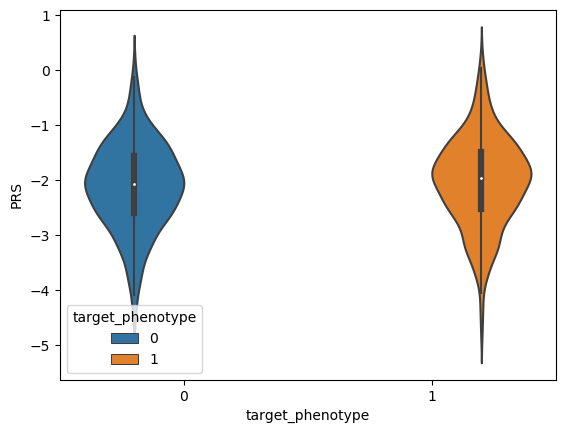

In [18]:
sns.violinplot(data=fenotipo_PRS,  y="PRS", x = 'target_phenotype', hue="target_phenotype")


In [19]:
file_2 = "s3://grupo2-brasileiros/snps-functional-classification.tsv"

In [20]:
snp_func = pd.read_csv(file_2, delimiter="\t")                          # anotação funcional dos SNPs

In [21]:
# criando "ID" com Cromossomo Posição Alelo chamado CPA com o alelo de efeito no hg38
# quem tem esse alelo (na população onde foi feito o PRS) tem o effect_weight
GRCh38['CPA_GRCh38'] = GRCh38['chr'].astype(str) + "-" + GRCh38['pos_hg38'].astype(str) + "-"+ GRCh38['effect_allele'].astype(str)
# criando um ID também em hg19 que é a mesma coisa que hg37
GRCh38['CPA_GRCh37'] = GRCh38['chr'].astype(str) + "-" + GRCh38['pos_hg19'].astype(str) + "-"+ GRCh38['effect_allele'].astype(str)
# criando esse mesmo ID para o snp_func para depois poder juntar essas duas tabelas
snp_func['CPA_snp_func_Hg19'] = "chr" + snp_func['chromosome'].astype(str) + "-" + snp_func['pos_hg19'].astype(str) + "-"+ snp_func['effect_allele'].astype(str)

In [22]:
dfinal_GRCh38_snp_func = GRCh38.merge(snp_func, how='left', left_on='CPA_GRCh37', right_on='CPA_snp_func_Hg19')

In [23]:
dfinal_GRCh38_snp_func['new_1'] = (dfinal_GRCh38_snp_func['consequence'] .isin([
    'missense_variant','3_prime_UTR_variant','5_prime_UTR_variant','synonymous_variant'])).astype(int)*dfinal_GRCh38_snp_func['sift'] 

In [24]:
dfinal_GRCh38_snp_func['new_2'] = (dfinal_GRCh38_snp_func['consequence'] .isin([
    'missense_variant','3_prime_UTR_variant','5_prime_UTR_variant','synonymous_variant'])).astype(int)*dfinal_GRCh38_snp_func['poly_phen'] 

In [25]:
dfinal_GRCh38_snp_func_2 = dfinal_GRCh38_snp_func[['consequence','Artery_Aorta', 'Artery_Coronary', 'Artery_Tibial', 'Bladder', 
                        'Heart_Atrial_Appendage', 'Heart_Left_Ventricle', 'Whole_Blood' ,'new_1','new_2','Kidney_Cortex','Whole_Blood', 'gene_set','gnom_ad_genome_amr']]

In [26]:
for i in dfinal_GRCh38_snp_func_2.columns[:-1]:
    dfinal_GRCh38_snp_func_2 = dfinal_GRCh38_snp_func_2.merge(pd.get_dummies(dfinal_GRCh38_snp_func_2[i], prefix = i), how = 'left', left_index=True, right_index=True)

In [27]:
dfinal_GRCh38_snp_func_2.drop(columns =['consequence','Artery_Aorta', 'Artery_Coronary', 'Artery_Tibial', 'Bladder', 
                        'Heart_Atrial_Appendage', 'Heart_Left_Ventricle', 'Whole_Blood' ,'new_1','new_2','Kidney_Cortex','Whole_Blood', 'gene_set','gnom_ad_genome_amr'], axis =1, inplace = True )

In [28]:
def load_effect_sizes_2(effect_sizes, i):
    """Get effect size for each variant"""
    # Example: load_effect_sizes("resources/prs-scores-PGS002296.tsv")
    effect_sizes = effect_sizes
    effect_sizes = effect_sizes[['chr', 'pos_hg38', 'effect_allele', i]].rename(columns = {i:'effect_weight'})
    effect_sizes['chr'] = effect_sizes['chr'].astype(str)
    effect_sizes['pos_hg38'] = effect_sizes['pos_hg38'].astype(int)
    effect_sizes['locus'] = effect_sizes['chr'].astype(str) + ':' + effect_sizes['pos_hg38'].astype(str) # pylint: disable=line-too-long
    effect_sizes_dict = effect_sizes[['locus', 'effect_weight', 'effect_allele']].set_index('locus').T.to_dict() # pylint: disable=line-too-long
    return effect_sizes_dict

In [29]:
dfinal_GRCh38_snp_func_2 = dfinal_GRCh38_snp_func_2.merge(
    dfinal_GRCh38_snp_func[['chr','pos_hg38_x','effect_allele_x']], how = 'left', left_index=True, right_index=True).rename(columns = 
                                                                                                                           {'pos_hg38_x':'pos_hg38', 'effect_allele_x':'effect_allele'})

In [30]:
prs_aux = calc_vcf_prs("target_cohort2.vcf", load_effect_sizes_2(dfinal_GRCh38_snp_func_2, 'consequence_3_prime_UTR_variant'))
prs_aux = pd.DataFrame(zip(list(prs_aux.keys()), list(prs_aux.values())))
prs_aux.iloc[:,1].values

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  if __name__ == '__main__':


array([28, 31, 32, ..., 33, 35, 30])

In [31]:
PRss =  prs_aux[[0]]
for i in dfinal_GRCh38_snp_func_2.columns[:-3]:
        prs_aux = calc_vcf_prs("target_cohort2.vcf", load_effect_sizes_2(dfinal_GRCh38_snp_func_2, i))
        prs_aux = pd.DataFrame(zip(list(prs_aux.keys()), list(prs_aux.values())))
        prs_aux.rename(columns = {1:i}, inplace = True)
        PRss =  PRss.merge(prs_aux, how = 'left', on = 0)
     


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  if __name__ == '__main__':


In [32]:
fenotipo_PRS

,s,PRS,target_phenotype,bmi,age,sex,pc1,pc2,pc3,pc4,pc5
0,Sample_62,-1.143,1,32.218000,61,M,-0.170593,-0.083687,-0.002978,0.036140,-0.014352
1,Sample_1029,-1.780,1,24.348423,71,F,-0.020599,-0.003149,0.004546,-0.008520,0.005531
2,Sample_821,-2.616,1,29.142830,61,F,-0.046461,-0.038442,-0.016533,-0.006880,0.011157
3,Sample_56,-1.682,1,27.539062,63,F,-0.116739,-0.045862,0.033690,0.029004,0.027046
4,Sample_47,-1.302,1,29.965397,63,M,-0.031261,-0.001217,-0.021570,0.005165,0.003345
...,...,...,...,...,...,...,...,...,...,...,...
1087,Sample_160,-1.774,0,18.420244,65,F,-0.215638,-0.036359,-0.012529,0.036099,0.006637
1088,Sample_443,-1.981,0,31.615793,68,M,-0.483780,0.039192,-0.004574,0.027172,0.002503
1089,Sample_326,-2.943,0,37.655820,77,F,-0.035433,-0.006781,-0.028934,0.000846,0.006089
1090,Sample_1080,-2.139,0,29.140661,72,M,-0.138432,-0.027647,-0.025699,0.015562,0.018976


In [33]:
PRss = PRss.merge(fenotipo_PRS[['s','PRS','target_phenotype']], how = 'right', left_on = 0, right_on='s').drop(columns = 0)

In [41]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(PRss.drop(columns = ['s','target_phenotype']))
teste = scaler.transform(PRss.drop(columns = ['s','target_phenotype']))


In [42]:
teste

array([[ 0.42066226,  0.69133828,  1.36996999, ...,  0.47588884,
         1.11787845,  1.32418477],
       [ 0.10516556, -0.95700539, -0.75849558, ...,  0.47588884,
         0.33057181, -0.39814462],
       [ 0.10516556, -0.95700539,  0.15370395, ...,  0.47588884,
        -0.7026909 , -0.07813188],
       ...,
       [-0.52582782, -0.95700539, -0.75849558, ...,  0.47588884,
        -1.10684988, -0.01908296],
       [ 0.10516556,  0.69133828, -0.75849558, ...,  0.47588884,
        -0.11313789, -0.77297649],
       [ 1.05165564, -0.95700539, -0.75849558, ..., -1.96387931,
         1.05978832, -0.35752803]])

In [43]:
PRss['means'] = teste.mean(axis = 1)

In [44]:
#PRss['means'] 

0       0.384585
1      -0.090066
2      -0.163102
3      -0.083140
4       0.091885
          ...   
1087    0.365986
1088    0.389770
1089    0.087268
1090   -0.082408
1091   -0.045718
Name: means, Length: 1092, dtype: float64

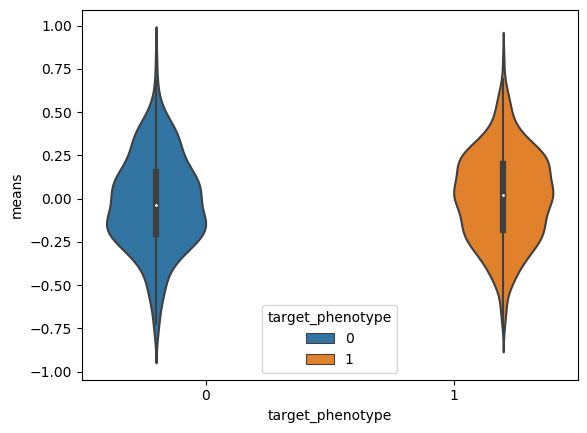

In [45]:
sns.violinplot(data=PRss,  y="means", x = 'target_phenotype', hue="target_phenotype")


In [ ]:
roc_auc_score(PRss['target_phenotype'],  PRSs['PRS'])